# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [4]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy, r_squared, mse, mae
from IPython.display import Image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [6]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

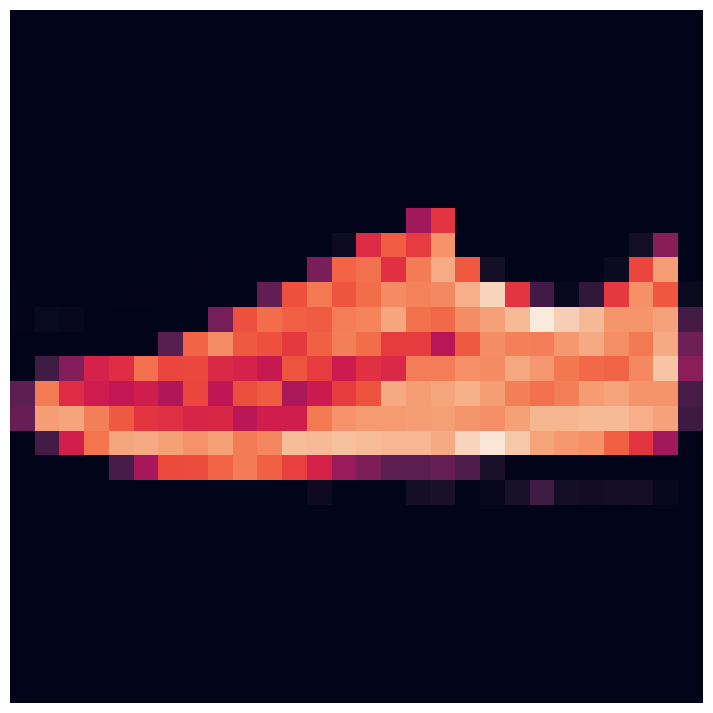

In [8]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

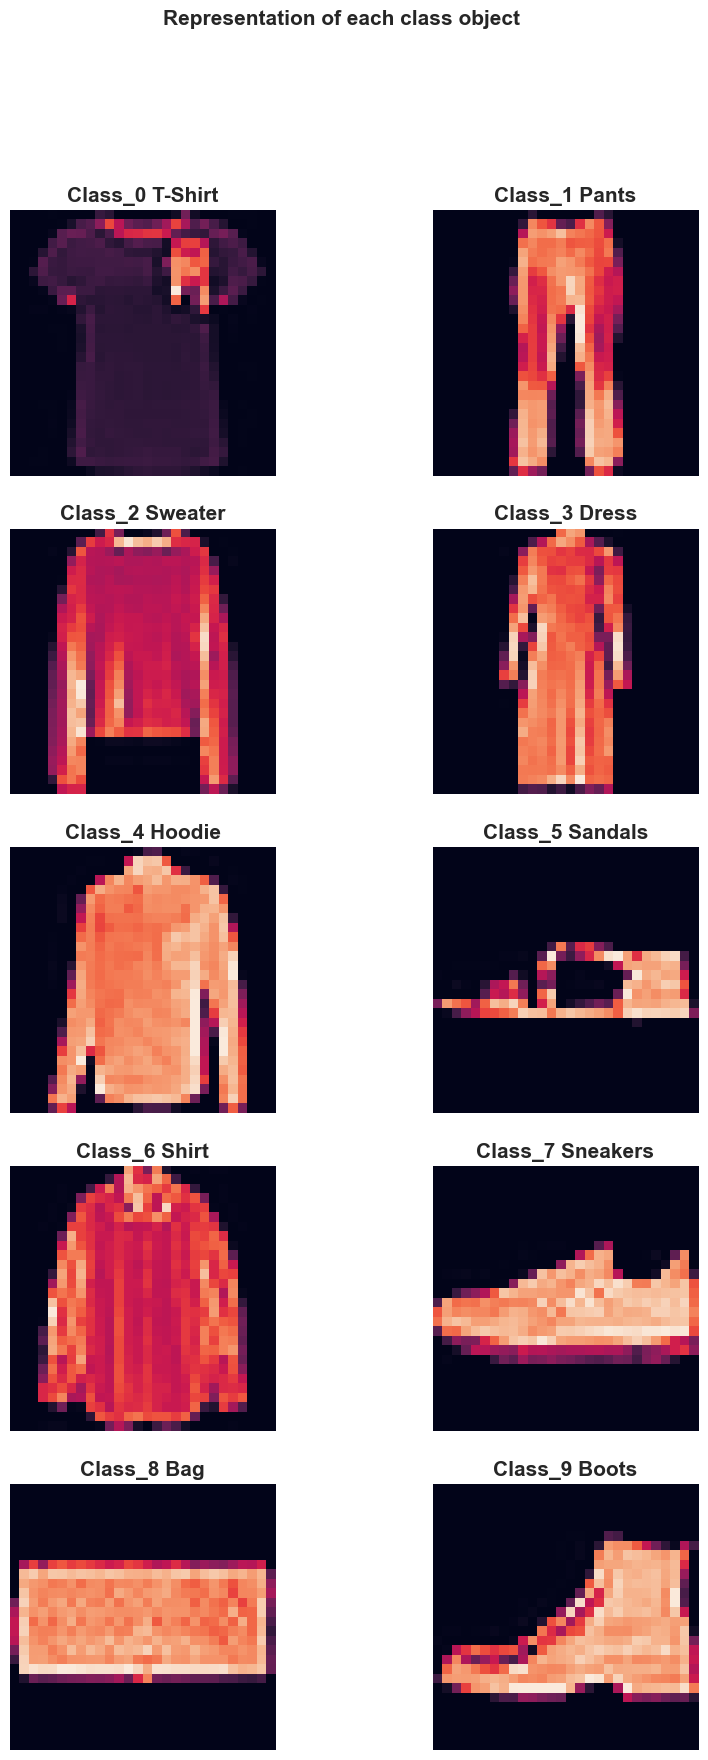

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

fig.suptitle("Representation of each class object", size=15, weight="bold")

class_nums = list(map(int, range(10)))

objects = [
    "T-Shirt",
    "Pants",
    "Sweater",
    "Dress",
    "Hoodie",
    "Sandals",
    "Shirt",
    "Sneakers",
    "Bag",
    "Boots"
]

object_class = 0
for row in axes:
    for col in row:
        object_index = np.where(y == str(object_class))[0][0]
        image = X[object_index].reshape(28, 28, 1)
        col.set_title(f'Class_{object_class} {objects[object_class]}', weight='bold', size=15)
        col.set_axis_off()
        col.imshow(image)
        object_class += 1


To identify adequately which exact pieces of clothing these were, I had to look through several images.


### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

In [10]:
_, object_count = np.unique(y, return_counts=True)

''

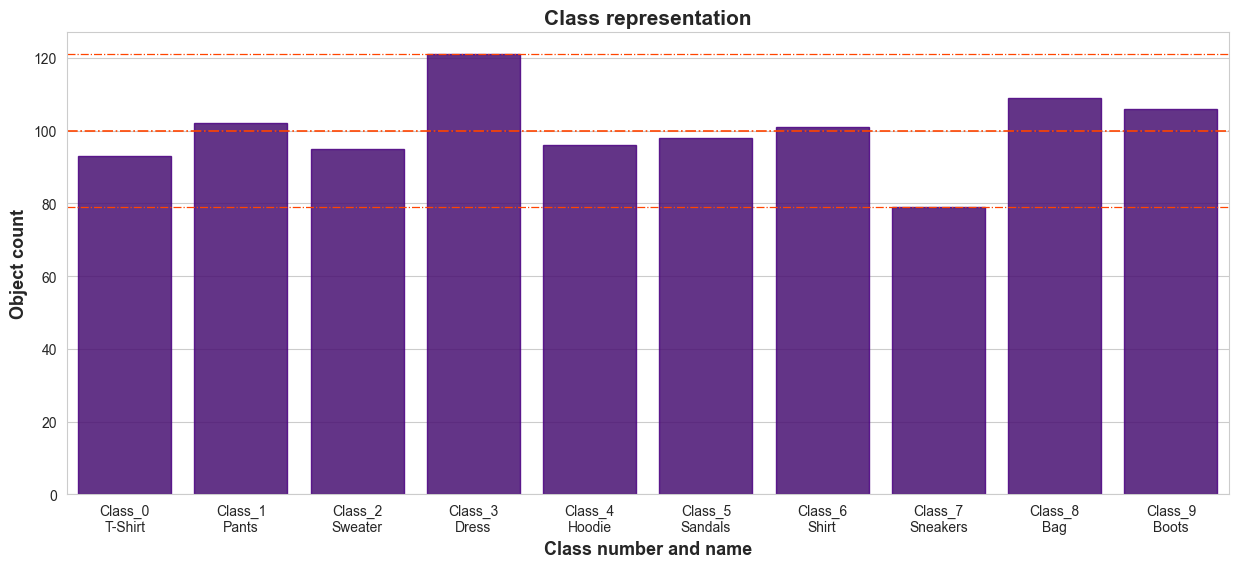

In [11]:
plt.figure(figsize=(15, 6))
sns.barplot(x=list(map(lambda x: f'Class_{objects.index(x)}\n{x}', objects)), 
            y=object_count,
            color="indigo",
            edgecolor="indigo",
            alpha=0.85)
plt.xlabel("Class number and name", size=13, weight="bold")
plt.ylabel("Object count", size=13, weight="bold")
plt.title("Class representation", size=15, weight="bold")
plt.axhline(y=object_count.min(), color='orangered', linestyle='-.', linewidth=0.9)
plt.axhline(y=object_count.max(), color='orangered', linestyle='-.', linewidth=0.9)
plt.axhline(y=object_count.mean(), color='orangered', linestyle='-.', linewidth=1.2)
;

In [12]:
print(f'Each class has at least {object_count.min()} objects in it. Class 7 "Sneakers" is the least represented ({object_count.min()} objects), class 3 "Dress" is the most represented ({object_count.max()} objects).')

Each class has at least 79 objects in it. Class 7 "Sneakers" is the least represented (79 objects), class 3 "Dress" is the most represented (121 objects).


Let's take a look at the target, notice that it is type int and correct it.

In [13]:
y.dtype

dtype('O')

In [14]:
y = y.astype(int)

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [15]:
X.shape, y.shape # checked the number of objects and that the objects number in features and target correspond; everything is ok

((1000, 784), (1000,))

In [16]:
test_proportion = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion, random_state=SEED)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [17]:
binary_train_X = X_train[np.where((y_train == 0) | (y_train == 1))]
binary_train_y = y_train[np.where((y_train == 0) | (y_train == 1))]
binary_test_X = X_test[np.where((y_test == 0) | (y_test == 1))]
binary_test_y = y_test[np.where((y_test == 0) | (y_test == 1))]

In [18]:
print(f"We have just selected from previously arranged train and test data sets objects of classes 0 and 1 only. We had no guarantee that the proportion of train/test still corresponds to the chosen proportion {int(100 - test_proportion * 100)}/{int(test_proportion * 100)}. So, let's check.")

We have just selected from previously arranged train and test data sets objects of classes 0 and 1 only. We had no guarantee that the proportion of train/test still corresponds to the chosen proportion 75/25. So, let's check.


In [19]:
binary_train_num_obj = binary_train_X.shape[0]
binary_test_num_obj = binary_test_X.shape[0]

print(f'binary_train_X.shape: {binary_train_X.shape}, binary_train_y.shape: {binary_train_y.shape}')
print(f'binary_test_X.shape: {binary_test_X.shape}, binary_test_y.shape: {binary_test_y.shape}')

binary_train_X.shape: (146, 784), binary_train_y.shape: (146,)
binary_test_X.shape: (49, 784), binary_test_y.shape: (49,)


In [20]:
print(f'Result: the proportion of test/train datasets of 0 and 1 classes is {binary_test_num_obj / binary_train_num_obj}. Almost close to {test_proportion}.')

Result: the proportion of test/train datasets of 0 and 1 classes is 0.3356164383561644. Almost close to 0.25.


И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [21]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [22]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
m = dists.shape[1] - 1
assert np.isclose(dists[0, m], np.sum(np.abs(binary_test_X[0] - binary_train_X[m])))

In [23]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, m], np.sum(np.abs(binary_test_X[0] - binary_train_X[m])))

In [24]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, m], np.sum(np.abs(binary_test_X[0] - binary_train_X[m])))

Проверим скорость работы реализованных методов

In [25]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

47.3 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.41 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.1 ms ± 825 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [26]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [27]:
# TODO: binary_classification_metrics in metrics.py

In [28]:
binary_classification_metrics(prediction, binary_test_y, beau=True)

Precision: 1.0
Recall: 1.0
F1-score: 1.0
Accuracy: 1.0


(1.0, 1.0, 1.0, 1.0)

Precision, Recall, Accuracy and F1-score seem to be perfect. To make sure that the dream came true and test data set is predicted perfectly, we can check it manually.

In [29]:
print(f'Real test set: {binary_test_y}.')
print(f'Predicted test set: {prediction}.')
print(f'Are the arrays of real and predicted data identique? {sum(binary_test_y == prediction) == len(prediction)}.')
print(f'{sum(binary_test_y == prediction)} of {prediction.shape[0]} objects are predicted correclty.')

Real test set: [1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1
 1 1 0 0 0 1 1 1 1 0 0 0].
Predicted test set: [1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0.].
Are the arrays of real and predicted data identique? True.
49 of 49 objects are predicted correclty.


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [31]:
print(f'Precision score (sklearn): {precision_score(binary_test_y, prediction)}')
print(f'Recall score (sklearn): {recall_score(binary_test_y, prediction)}')
print(f'F1-score score (sklearn): {f1_score(binary_test_y, prediction)}')
print(f'Accuracy score (sklearn): {accuracy_score(binary_test_y, prediction)}')

Precision score (sklearn): 1.0
Recall score (sklearn): 1.0
F1-score score (sklearn): 1.0
Accuracy score (sklearn): 1.0


### Подбор оптимального k

Чтобы подобрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [32]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric, beau=False):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    """
    YOUR CODE IS HERE
    """

    result_train = list()
    result_test = list()
    metrics_list = [precision_score, recall_score, f1_score, accuracy_score]    

    for neighbour_number in params:
        knn_classifier_search = KNNClassifier(k=neighbour_number)
        knn_classifier_search.fit(X_train, y_train)

        prediction_search_train = knn_classifier_search.predict(X_train)
        prediction_search_test = knn_classifier_search.predict(X_test)

        if len(np.unique(y, return_counts=True)[1]) == 2:
            metric_train = binary_classification_metrics(prediction_search_train, y_train)[metrics_list.index(metric)]
            metric_test = binary_classification_metrics(prediction_search_test, y_test)[metrics_list.index(metric)]
        
        elif len(np.unique(y, return_counts=True)[1]) > 2:
            metric_train = multiclass_accuracy(prediction_search_train, y_train)
            metric_test = multiclass_accuracy(prediction_search_test, y_test)

        if beau:
            print(f'K number: {neighbour_number}')
            print(f'Train dataset metric: {metric_train}')
            print(f'Test dataset metric: {metric_test}')

        result_train.append(metric_train)
        result_test.append(metric_test)

    return result_train, result_test

In [33]:
#params = [1, 2, 3, 4, 5, 7, 8, 10, 30]
params = list(range(1, 31))
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score, beau=False)

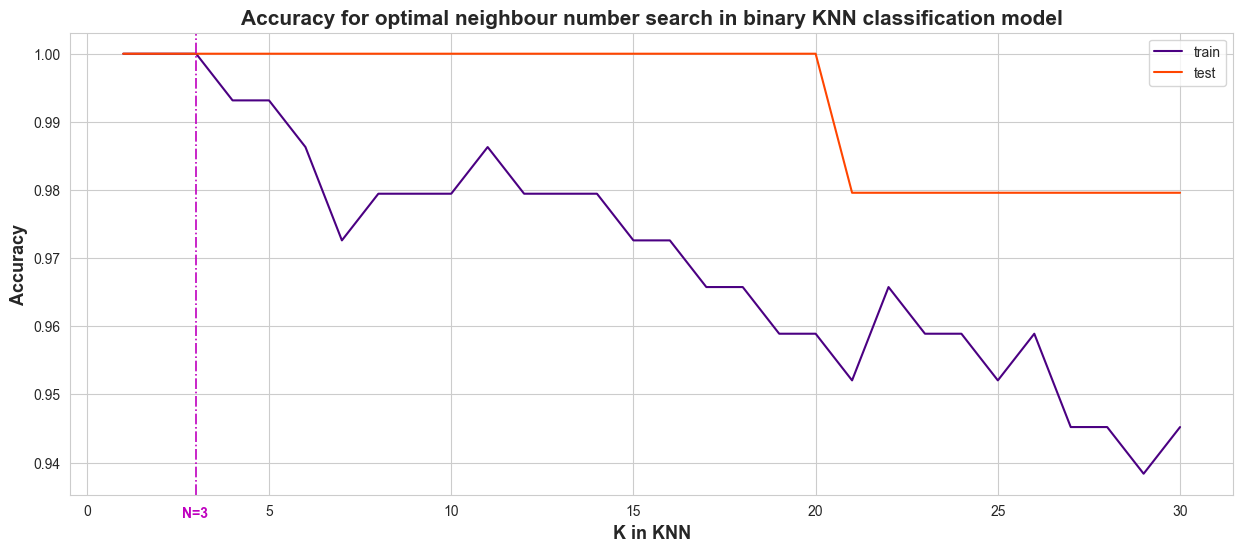

In [34]:
plt.figure(figsize=(15, 6))
plt.title("Accuracy for optimal neighbour number search in binary KNN classification model", size=15, weight="bold")
plt.plot(params, np.array(train_metrics), label="train", color='indigo')
plt.plot(params, np.array(test_metrics), label="test", color='orangered')
plt.legend()
plt.xlabel("K in KNN", size=13, weight="bold")
plt.ylabel("Accuracy", size=13, weight="bold")
plt.axvline(x=3, color='m', linestyle='-.', linewidth=1.2)
plt.text(x=2.6, y=0.932, s="N=3", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'm'});

It seems that the best neighbour number is 3.

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

Now actually I wanted to write the function that would return all four sets of metrics. If the memory affords you that, of course.
So actually I think that it'd better look like that:

In [35]:
def find_best_k_2(X_train, y_train, X_test, y_test, params, beau=False):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of four lists of all metric values on train data set for each k in params
    test_metrics the list of four lists of all metric values on test data set for each k in params
    """
    
    """
    YOUR CODE IS HERE
    """

    result_train = list()
    result_test = list()

    prec_train_list = list()
    rec_train_list = list()
    f1_train_list = list()
    acc_train_list = list()

    prec_test_list = list()
    rec_test_list = list()
    f1_test_list = list()
    acc_test_list = list()

    for neighbour_number in params:
        knn_classifier_search = KNNClassifier(k=neighbour_number)
        knn_classifier_search.fit(X_train, y_train)

        prediction_search_train = knn_classifier_search.predict(X_train)
        prec_train, rec_train, f1_train, acc_train = binary_classification_metrics(prediction_search_train, y_train)        
        
        prediction_search_test = knn_classifier_search.predict(X_test)
        prec_test, rec_test, f1_test, acc_test = binary_classification_metrics(prediction_search_test, y_test)

        if beau:
            print(f'K number: {neighbour_number}')
            print(f'Train dataset metrics: Precision {prec_train} Recall {rec_train} F1-score {f1_train} Accuracy {acc_train}')
            print(f'Test dataset metrics: Precision {prec_test} Recall {rec_test} F1-score {f1_test} Accuracy {acc_test}')
        
        prec_train_list.append(prec_train)
        rec_train_list.append(rec_train)
        f1_train_list.append(f1_train)
        acc_train_list.append(acc_train)
        prec_test_list.append(prec_test)
        rec_test_list.append(rec_test)
        f1_test_list.append(f1_test)
        acc_test_list.append(acc_test)

    result_train.extend((prec_train_list, rec_train_list, f1_train_list, acc_train_list))
    result_test.extend((prec_test_list, rec_test_list, f1_test_list, acc_test_list))

    return result_train, result_test

In [36]:
params = list(range(1, 31))
train_metrics, test_metrics = find_best_k_2(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, beau=False)

Text(0.5, 0, 'K in KNN')

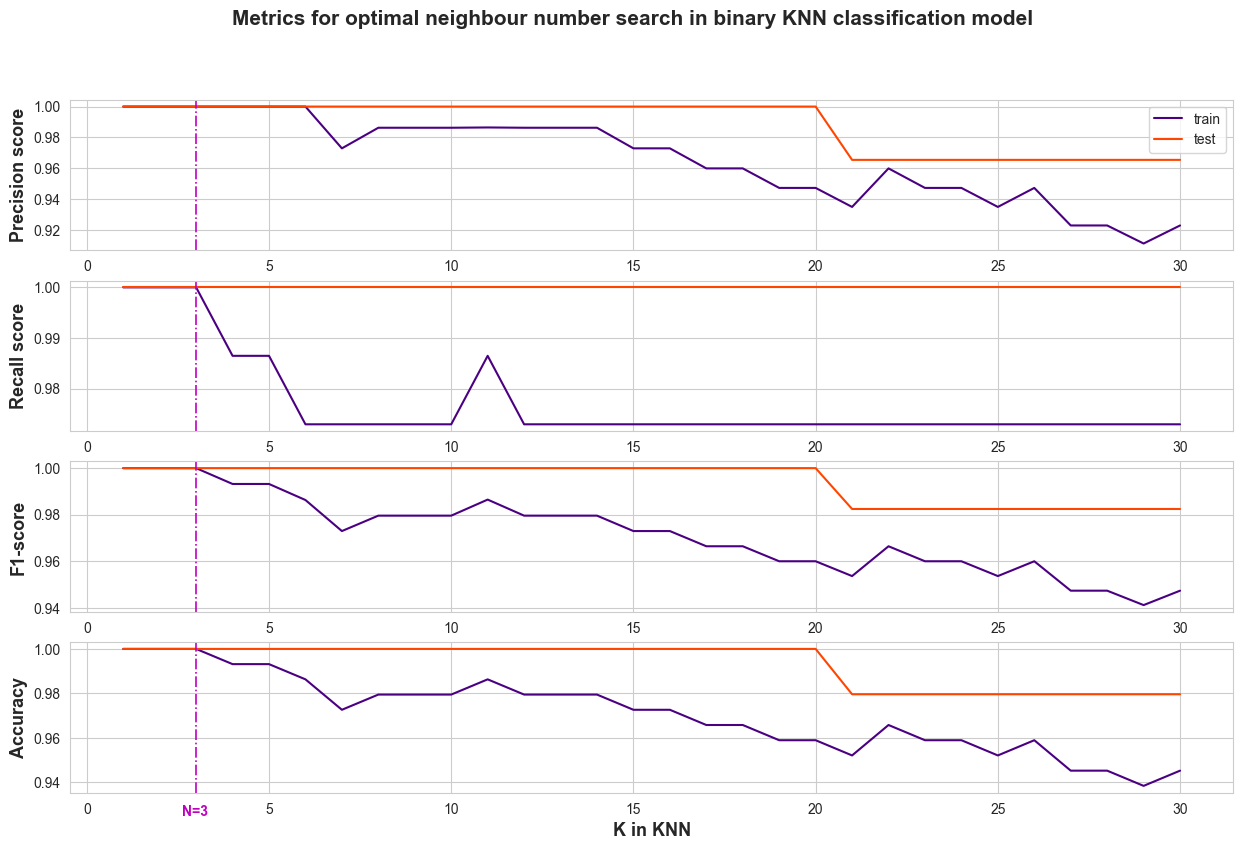

In [37]:
figure, axis = plt.subplots(4, 1, figsize=(15, 9))

figure.suptitle("Metrics for optimal neighbour number search in binary KNN classification model", size=15, weight="bold")

axis[0].plot(params, np.array(train_metrics[0]), label="train", color='indigo')
axis[0].plot(params, np.array(test_metrics[0]), label="test", color='orangered')
axis[0].legend()
axis[0].set_ylabel("Precision score", size=13, weight="bold")
axis[0].axvline(x=3, color='m', linestyle='-.', linewidth=1.2)

axis[1].plot(params, np.array(train_metrics[1]), label="train", color='indigo')
axis[1].plot(params, np.array(test_metrics[1]), label="test", color='orangered')
axis[1].set_ylabel("Recall score", size=13, weight="bold")
axis[1].axvline(x=3, color='m', linestyle='-.', linewidth=1.2)

axis[2].plot(params, np.array(train_metrics[2]), label="train", color='indigo')
axis[2].plot(params, np.array(test_metrics[2]), label="test", color='orangered')
axis[2].set_ylabel("F1-score", size=13, weight="bold")
axis[2].axvline(x=3, color='m', linestyle='-.', linewidth=1.2)

axis[3].plot(params, np.array(train_metrics[3]), label="train", color='indigo')
axis[3].plot(params, np.array(test_metrics[3]), label="test", color='orangered')
axis[3].set_ylabel("Accuracy", size=13, weight="bold")
axis[3].axvline(x=3, color='m', linestyle='-.', linewidth=1.2)

axis[3].text(x=2.6, y=0.925, s="N=3", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'm'})
axis[3].set_xlabel("K in KNN", size=13, weight="bold")

It seems that the best neighbour number is 3 for binary classification.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [38]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [39]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.764

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [40]:
params = list(range(1, 31))
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, accuracy_score, beau=False)

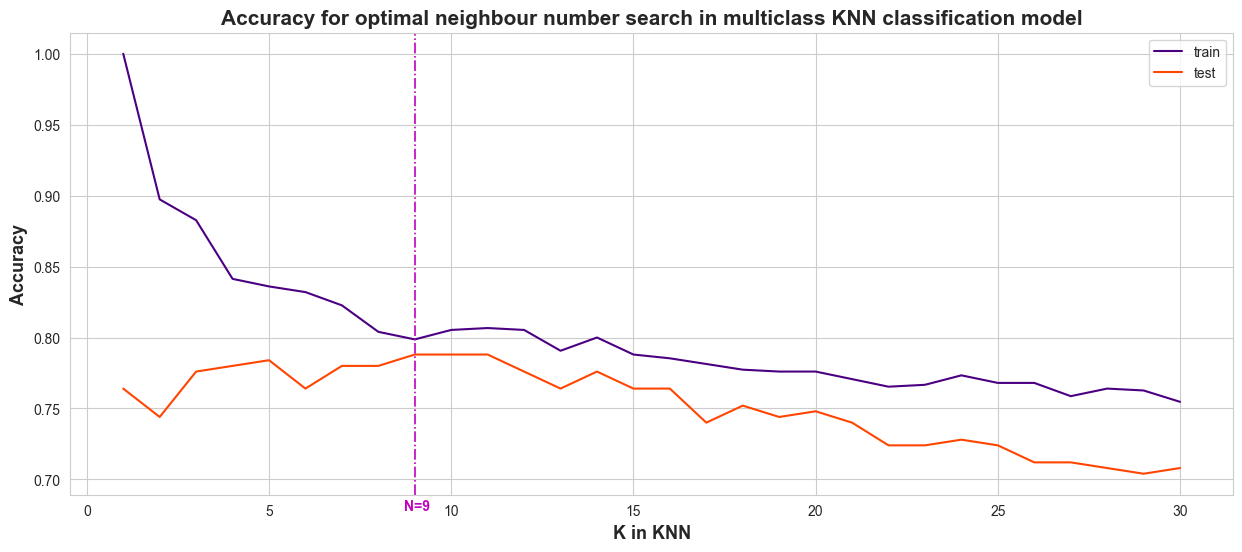

In [41]:
plt.figure(figsize=(15, 6))
plt.title("Accuracy for optimal neighbour number search in multiclass KNN classification model", size=15, weight="bold")
plt.plot(params, np.array(train_metrics), label="train", color='indigo')
plt.plot(params, np.array(test_metrics), label="test", color='orangered')
plt.legend()
plt.xlabel("K in KNN", size=13, weight="bold")
plt.ylabel("Accuracy", size=13, weight="bold")
plt.axvline(x=9, color='m', linestyle='-.', linewidth=1.2)
plt.text(x=8.7, y=0.678, s="N=9", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'm'});

Ir seems like the optimal neighbour number for multiclass classification is 9. Yet accuracy for test dataset is the same for 9, 10 and 11 neigbours in model, I suppose the less the better.

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [42]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [43]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [44]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [45]:
from sklearn.pipeline import Pipeline

In [46]:
X.shape

(442, 10)

In [47]:
X.mean()

age   -2.511817e-19
sex    1.230790e-17
bmi   -2.245564e-16
bp    -4.797570e-17
s1    -1.381499e-17
s2     3.918434e-17
s3    -5.777179e-18
s4    -9.042540e-18
s5     9.293722e-17
s6     1.130318e-17
dtype: float64

In [48]:
X.std()

age    0.047619
sex    0.047619
bmi    0.047619
bp     0.047619
s1     0.047619
s2     0.047619
s3     0.047619
s4     0.047619
s5     0.047619
s6     0.047619
dtype: float64

Despite the means are close to 0 and stds are not close to 1. Basically all data have the same means and stds so they don't need to be standardized. I'll do it just for training.

Let's take a look at the feature distribution. Seems normlal, except categorial sex.

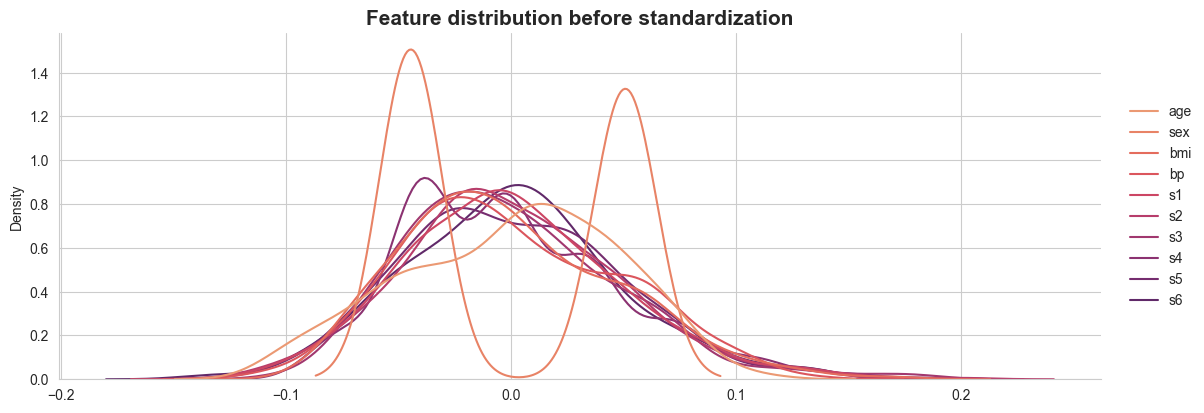

In [49]:
sns.displot(data=X, kind='kde', palette='flare', height=4, aspect=17/6)
plt.title("Feature distribution before standardization", size=15, weight="bold");

In [50]:
X.sex.nunique(), X.sex.unique() # very unusual sex labels wanna make them 0 and 1

(2, array([ 0.05068012, -0.04464164]))

Splitting data into train and test datasets.

In [51]:
test_proportion = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion, random_state=SEED)

Let's divide data into numeric and categorial components to transform them independently.

In [52]:
X.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [53]:
cat_cols = ['sex']
num_cols = ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

First of all, I will standardise data manually using StandardScaler for numeric data and OheHotEncoder for categorial data(sex).

In [54]:
scaler = StandardScaler()
scaler.fit(X_train.drop('sex', axis=1))
all_scaled = scaler.transform(X_train.drop('sex', axis=1))

In [55]:
ohe = OneHotEncoder(sparse=False, drop="first")
ohe.fit(X_train[['sex']])
sex_only_cat = ohe.transform(X_train[['sex']])

/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Now I will make the preprocessor implying both these methods.

In [56]:
preprocessor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), num_cols),
                  ("ohe", OneHotEncoder(drop="first"), cat_cols)]
)

In [57]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4',
                                  's5', 's6']),
                                ('ohe', OneHotEncoder(drop='first'), ['sex'])])

In [58]:
preprocessor.transformers

[('scaler',
  StandardScaler(),
  ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']),
 ('ohe', OneHotEncoder(drop='first'), ['sex'])]

Now let me check if preprocessor correctly transforms data (for example first feature *age* and last feature *sex*).
For these features I'll just count how many values do not match after manual transformation and preprocessor transformation.

In [59]:
needed_shape = preprocessor.transform(X_train)[ : , -1].shape # info for reshaping for correct estimation

In [60]:
print(f'Number of non-identique transformed values in age feature is {np.sum((preprocessor.fit_transform(X_train)[ : , 1] == all_scaled) == False)}')
print(f'Number of non-identique transformed values in sex feature is {np.sum((preprocessor.fit_transform(X_train)[ : , -1] == sex_only_cat.reshape(needed_shape)) == False)}')

Number of non-identique transformed values in age feature is 1
Number of non-identique transformed values in sex feature is 0


/tmp/ipykernel_10728/2259892305.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(f'Number of non-identique transformed values in age feature is {np.sum((preprocessor.fit_transform(X_train)[ : , 1] == all_scaled) == False)}')


In [61]:
X_train_preproc = preprocessor.transform(X_train)
X_test_preproc = preprocessor.transform(X_test)

Manually check means and stds of numeric features after manual and preprocessor transformation on train dataset. Perfect match. 

(sorry just had to do it for myself to make sure preprocessor transforms correctly)

In [62]:
print('Manually:')
for feature in range(len(X_train.columns) - 1): # -1 bcs i have no interest of categorical feature mean and std 
    print(f'{X_train.columns[feature]} mean: {X_train_preproc[ : , feature].mean()}, std: {X_train_preproc[ : , feature].std()}')

Manually:
age mean: -2.1466547908160126e-17, std: 1.0
sex mean: 2.6833184885200158e-18, std: 1.0
bmi mean: 2.6833184885200158e-18, std: 1.0
bp mean: 1.878322941964011e-17, std: 1.0
s1 mean: 5.3666369770400316e-18, std: 1.0
s2 mean: 1.1404103576210068e-17, std: 0.9999999999999999
s3 mean: 1.341659244260008e-17, std: 1.0
s4 mean: -1.0733273954080063e-17, std: 1.0
s5 mean: -3.4883140350760205e-17, std: 1.0


In [63]:
print('Preprocessor:')
for feature in range(len(scaler.feature_names_in_)):
    print(f'{scaler.feature_names_in_[feature]} mean: {all_scaled[ : , feature].mean()}, std: {all_scaled[ : , feature].std()}')

Preprocessor:
age mean: -2.1466547908160126e-17, std: 1.0
bmi mean: 2.6833184885200158e-18, std: 1.0
bp mean: 2.6833184885200158e-18, std: 1.0
s1 mean: 1.878322941964011e-17, std: 1.0
s2 mean: 5.3666369770400316e-18, std: 1.0
s3 mean: 1.1404103576210068e-17, std: 0.9999999999999999
s4 mean: 1.341659244260008e-17, std: 1.0
s5 mean: -1.0733273954080063e-17, std: 1.0
s6 mean: -3.4883140350760205e-17, std: 1.0


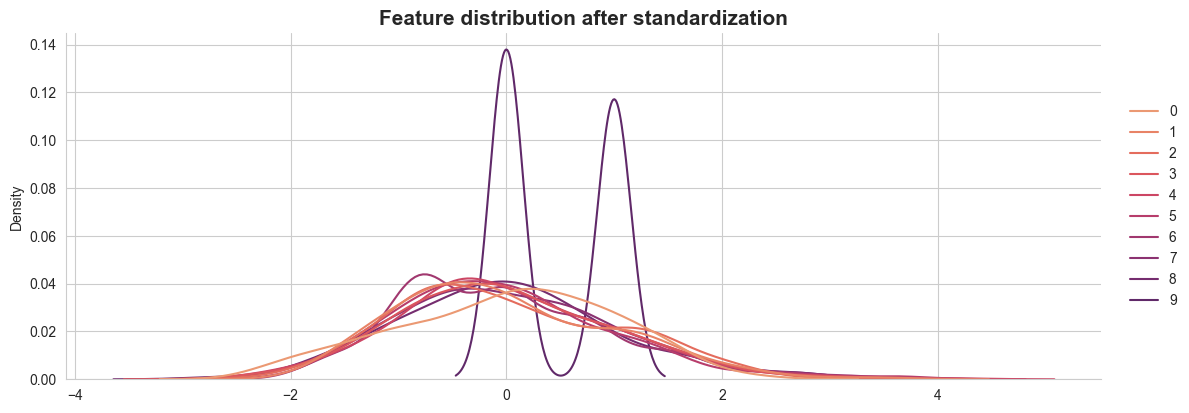

In [64]:
sns.displot(data=X_train_preproc, kind='kde', palette='flare', height=4, aspect=17/6)
plt.title("Feature distribution after standardization", size=15, weight="bold");

In [65]:
np.unique(X_train_preproc[ : , -1]) # sex has only two categories 0 and 1 now

array([0., 1.])

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на тренировочных данных и сделайте предсказания.

In [66]:
knn_regr = KNeighborsRegressor(n_neighbors=7, n_jobs=4)
knn_regr.fit(X_train_preproc, y_train)
y_pred = knn_regr.predict(X_test_preproc)

In [67]:
y_pred

array([186.28571429, 109.28571429, 161.42857143, 147.85714286,
       156.        , 197.71428571, 118.        , 110.14285714,
       104.42857143,  88.57142857, 131.42857143, 235.        ,
       218.14285714, 227.        , 181.71428571, 170.71428571,
       162.28571429, 139.42857143, 233.28571429,  77.14285714,
       102.57142857, 145.71428571, 140.14285714, 219.57142857,
        77.57142857, 106.        ,  58.57142857, 131.        ,
       199.57142857, 132.57142857, 172.71428571, 135.        ,
       181.85714286, 170.        , 139.        , 118.28571429,
        95.        , 170.85714286, 168.14285714, 132.        ,
       170.57142857, 281.42857143, 146.        , 127.42857143,
       164.        ,  87.42857143, 198.85714286, 100.42857143,
       205.28571429, 168.        , 161.71428571, 226.42857143,
       263.85714286, 113.        , 212.14285714, 112.57142857,
       115.57142857, 193.71428571,  83.42857143,  81.        ,
        80.14285714, 105.85714286, 188.14285714, 115.71

In [68]:
error = y_test - y_pred

In [69]:
np.mean(error), np.std(error)

(1.395109395109395, 56.50176396133813)

In [70]:
knn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", KNeighborsRegressor(
        n_neighbors=7,
        n_jobs=4
    ))])

In [71]:
knn_pipeline.fit(X_train, y_train)
y_pred_pipe = knn_pipeline.predict(X_test)
print(f'Number of non-identique predictions between manual method and pipeline are {np.sum((y_pred == y_pred_pipe) == False)}')

Number of non-identique predictions between manual method and pipeline are 0


### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [72]:
# TODO: r_squared, mse, mae in metrics.py
print(f'R2-score calculated by metrics module: {r_squared(y_pred_pipe, y_test)}')
print(f'R2-score calculated by sklearn: {r2_score(y_test, y_pred_pipe)}')
print(f'MSE-score calculated by metrics module: {mse(y_pred_pipe, y_test)}')
print(f'MSE-score calculated by sklearn: {mean_squared_error(y_test, y_pred_pipe)}')
print(f'MAE-score calculated by metrics module: {mae(y_pred_pipe, y_test)}')
print(f'MAE-score calculated by sklearn: {mean_absolute_error(y_test, y_pred_pipe)}')

R2-score calculated by metrics module: 0.362635953687114
R2-score calculated by sklearn: 0.362635953687114
MSE-score calculated by metrics module: 3194.3956609670895
MSE-score calculated by sklearn: 3194.3956609670895
MAE-score calculated by metrics module: 45.001287001287
MAE-score calculated by sklearn: 45.001287001287


### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [73]:
from metrics import r_squared, mse, mae

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

In [74]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    """
    YOUR CODE IS HERE
    """

    result_train = list()
    result_test = list()

    r_sq_train = list()
    mse_train = list()
    mae_train = list()
    r_sq_test = list()
    mse_test = list()
    mae_test = list()
    
    for neighbour_number in params:
        knn_regressor_search = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("knn", KNeighborsRegressor(
                n_neighbors=neighbour_number,
                n_jobs=4
                ))])

        knn_regressor_search.fit(X_train, y_train)
        y_pred_train = knn_regressor_search.predict(X_train)
        y_pred_test = knn_regressor_search.predict(X_test)

        if metric == "r2":
            result_train.append(r_squared(y_pred_train, y_train))
            result_test.append(r_squared(y_pred_test, y_test))
        elif metric == "mse":
            result_train.append(mse(y_pred_train, y_train))
            result_test.append(mse(y_pred_test, y_test))
        elif metric == "mae":
            result_train.append(mae(y_pred_train, y_train))
            result_test.append(mae(y_pred_test, y_test))

        elif metric == "all":
            r_sq_train.append(r_squared(y_pred_train, y_train))
            r_sq_test.append(r_squared(y_pred_test, y_test))           
            mse_train.append(mse(y_pred_train, y_train))
            mse_test.append(mse(y_pred_test, y_test))
            mae_train.append(mae(y_pred_train, y_train))
            mae_test.append(mae(y_pred_test, y_test))
        
    if len(result_train) == len(result_test) == 0:
        result_train.extend((r_sq_train, mse_train, mae_train))
        result_test.extend((r_sq_test, mse_test, mae_test)) 

    return result_train, result_test

In [75]:
params = list(range(1, 31))
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, "all")

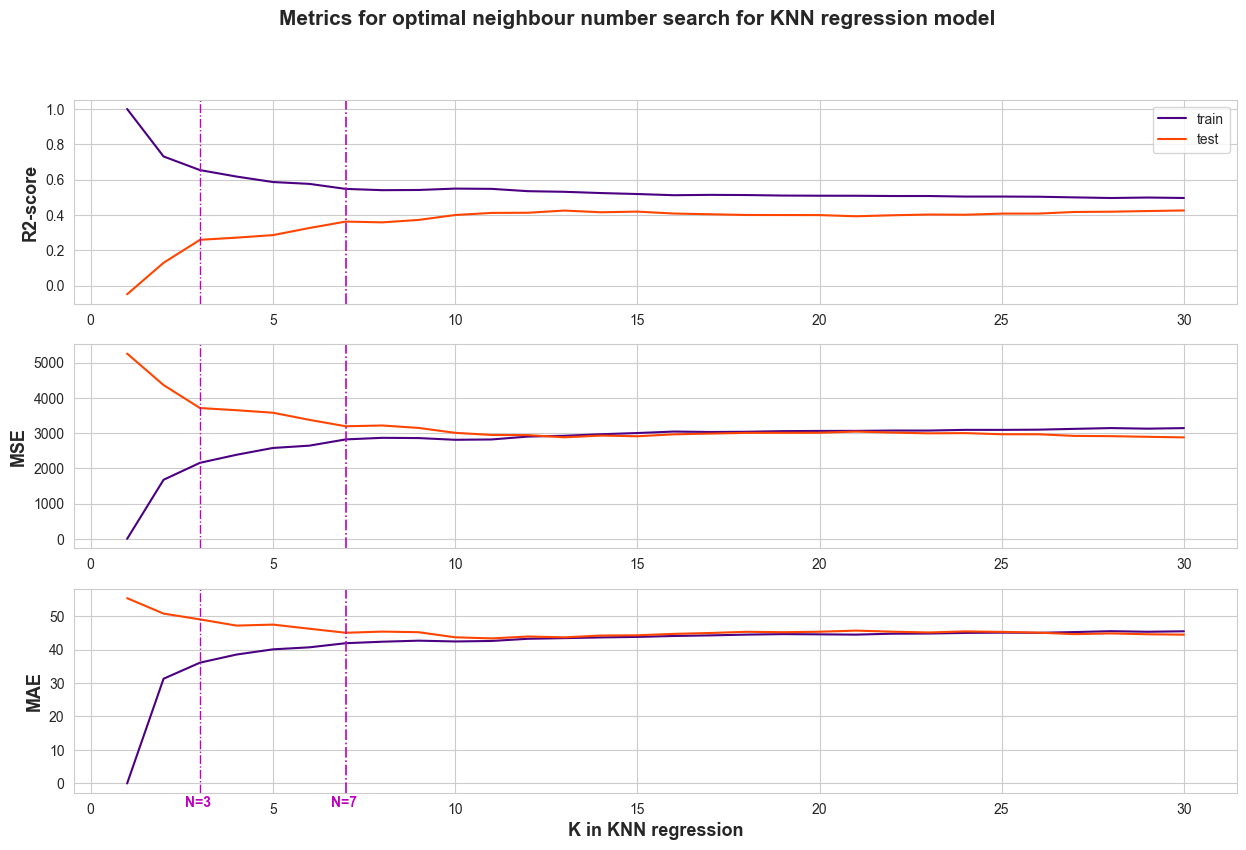

In [76]:
figure, axis = plt.subplots(3, 1, figsize=(15, 9))

figure.suptitle("Metrics for optimal neighbour number search for KNN regression model", size=15, weight="bold")

axis[0].plot(params, np.array(train_metrics[0]), label="train", color='indigo')
axis[0].plot(params, np.array(test_metrics[0]), label="test", color='orangered')
axis[0].legend()
axis[0].set_ylabel("R2-score", size=13, weight="bold")
axis[0].axvline(x=7, color='m', linestyle='-.', linewidth=1.2)
axis[0].axvline(x=3, color='m', linestyle='-.', linewidth=1)

axis[1].plot(params, np.array(train_metrics[1]), label="train", color='indigo')
axis[1].plot(params, np.array(test_metrics[1]), label="test", color='orangered')
axis[1].set_ylabel("MSE", size=13, weight="bold")
axis[1].axvline(x=7, color='m', linestyle='-.', linewidth=1.2)
axis[1].axvline(x=3, color='m', linestyle='-.', linewidth=1)

axis[2].plot(params, np.array(train_metrics[2]), label="train", color='indigo')
axis[2].plot(params, np.array(test_metrics[2]), label="test", color='orangered')
axis[2].set_ylabel("MAE", size=13, weight="bold")
axis[2].axvline(x=7, color='m', linestyle='-.', linewidth=1.2)
axis[2].axvline(x=3, color='m', linestyle='-.', linewidth=1)

axis[2].text(x=6.6, y=-7, s="N=7", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'm'})
axis[2].text(x=2.6, y=-7, s="N=3", fontdict={'fontsize': 10, 'fontweight': 'bold', 'color': 'm'})
axis[2].set_xlabel("K in KNN regression", size=13, weight="bold");

I suppose the best neighbours number for KNN-regression is 7 because it is the last elbow on the plot.

But if you lack computational resources or have enormous datasets or are time limited then you can sacrifice  the minor regression quality and choose 3 neighbours (the first critical plot elbow).

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

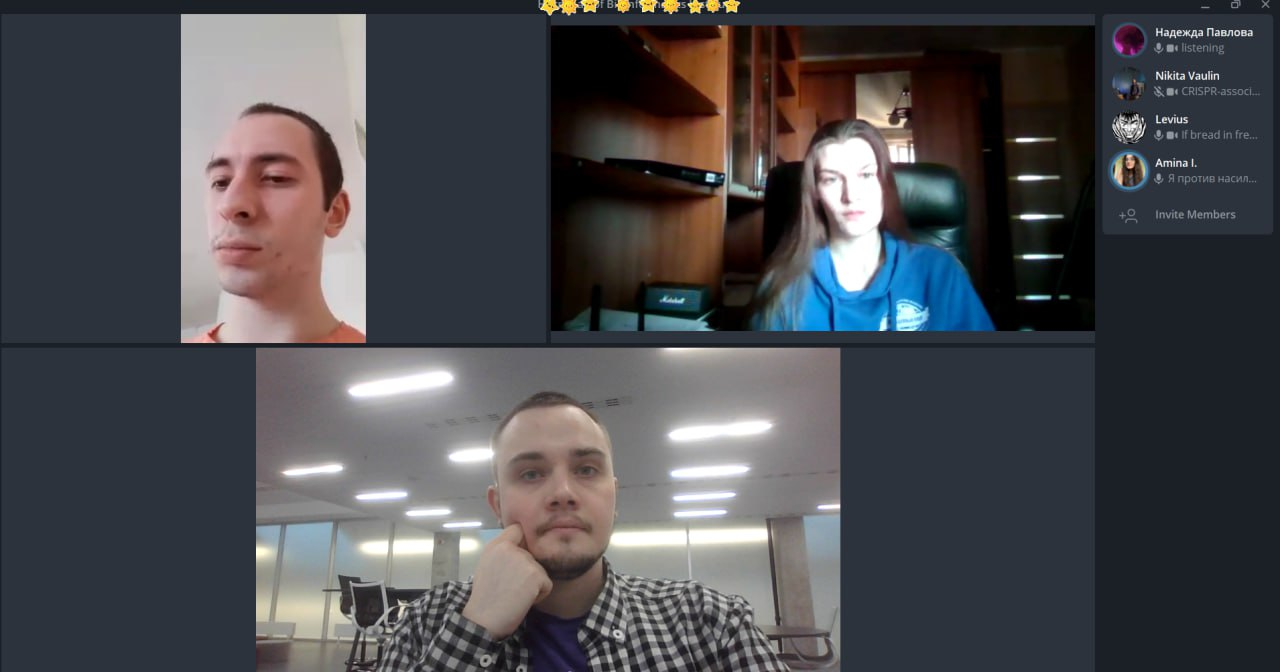

In [79]:
Image("call.jpg")

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

*It was beautiful and nothing hurt.*

(Take this literally if you wish or remember what this quote was about to fully understand the impression of the task.)